In [10]:
# ! pip install sweetviz # run this just if not installed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

## Exploratory Data Analysis

#### Preliminary Data Explore

In [2]:
train = pd.read_csv("data/train.csv")
test= pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [4]:
train.drop('id', axis=1, inplace=True);
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [5]:
train.dtypes

no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                         int64
required_car_parking_space                int64
room_type_reserved                        int64
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                       int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                            int64
dtype: object

In [6]:
train.shape

(42100, 18)

In [7]:
print ("total null values : ", train.isna().sum().sum())  # No null values

total null values :  0


In [8]:
print ("Total duplicate rows :", train.drop_duplicates().shape[0] - train.shape[0])

Total duplicate rows : 0


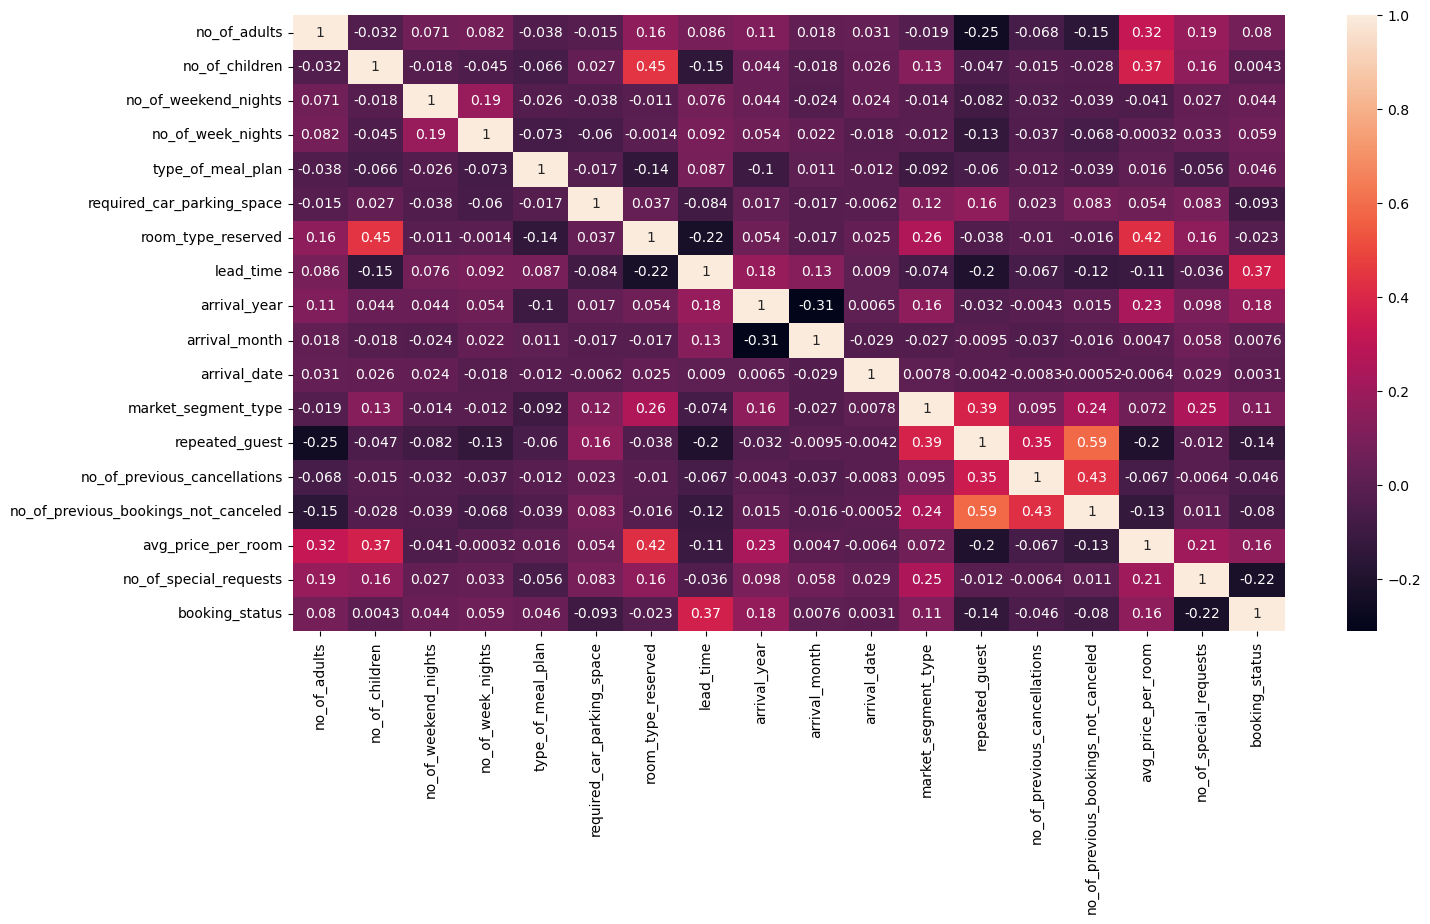

In [9]:
plt.figure(figsize=(16,8))
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True);


Some correlations but not problematic (around 0.5) between no_of_previous_booking_not_canceled , no_of_previous_booking_cancellations and repeated_guess. Makes sense, when a customer recurrent use a hotel (for instance for business purpose) probably have more booking without cancellation in that hotel, and also can eventually cancel the booking. The 3 variables will be maintained as they provide important information to the model. 

In [58]:
# Initial features clasification 

categorical = [
    'type_of_meal_plan',  # One hot encoding
    'required_car_parking_space',# Binary, no need of One hot encoding
    'room_type_reserved', # One hot enconding
    'market_segment_type', # One hot encoding
    'repeated_guest', # Binary, no need of One hot encoding
    
    
]
numerical_continous = [
    'avg_price_per_room', 
    'lead_time', # Number of days between the date of booking and the arrival date
]

numerical_discrete =[ 
    'no_of_previous_cancellations', 
    'no_of_previous_bookings_not_canceled',
    'no_of_week_nights',  # nteger but meaningful, hence treated as numerical features
    'no_of_weekend_nights',  # nteger but meaningful, hence treated as numerical features
    'no_of_adults', # integer but meaningful, hence treated as numerical features
    'no_of_children',  # integer but meaningful, hence treated as numerical features 
    #no_of_people to be added
    'no_of_special_requests',  # One hot encoding
]

others = [
    'arrival_date', # Crate a seasonal sinuoidal feature mixing date (day of the month) ,  month
    'arrival_month',# covered above 
    'arrival_year', # covered above, (check also 
    # yearly_seasonal
    # day of the year
]
target = ['booking_status']

#### Day of the year feature

Day, month and year are given as indepent values. It s very likely that booking has yearly seasonality. To allow ML model learn from that seasonality factor let 's create a compound of sin and cos seasonal features to allow the model to undertand the seasonality. (e.g. 2 of jaunary has more relation with 30 of december than with 1 of febrary...) 

In [70]:
train[(train['arrival_date']==29) & (train['arrival_month']==2 )]['arrival_year'].unique() # insight

array([2018])

!! 2018 is not an leap-year !!! 

There are observations with yyyy-02-29, what cause error when converting to date. 

There are also some dates obvserved out of the range of the month (for instance 31st days in september). To fix this anomalies, those dates will be approximates with the maximun date of the month possible. 

In [15]:
def time_stamper(year,month,date):
    # returns timestamps,modifying date to maximun date allowed for an specific month if exceeded
    max_date = pd.to_datetime(str(year)+str(month), format = '%Y%m').days_in_month
    if date <= max_date: # max possible days in that month
        return pd.to_datetime(str(year)+str(month)+str(date), format = '%Y%m%d')
    else:
        return pd.to_datetime(str(year)+str(month)+str(max_date), format = '%Y%m%d')

In [54]:
# Step 1 timestamp
train['timestamp'] = train.apply(lambda x: time_stamper(int(x['arrival_year']), int(x['arrival_month']), int(x['arrival_date'])), axis=1)

In [55]:
# Step 2 day of the year
train['arrival_day_of_year'] = train['timestamp'].apply(lambda x:x.dayofyear)

In [69]:
# step 3 - seasonal feature sin(2*pi*x/period) and sin(2*pi*x/period) 
train['yearly_seasonal_1'] = np.sin(2*np.pi*train['arrival_day_of_year']/365)
train['yearly_seasonal_2'] = np.cos(2*np.pi*train['arrival_day_of_year']/365)

In [65]:
train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,timestamp,arrival_day_of_year,yearly_seasonal,yearly_seasonal_1,yearly_seasonal_2
0,2,0,0,2,1,0,0,9,2018,1,...,11,0,67.50,0,0,2018-11-04,308,-0.831171,-0.831171,0.556017
1,2,0,1,2,0,0,0,117,2018,7,...,0,0,72.25,0,0,2018-07-29,210,-0.455907,-0.455907,-0.890028
2,2,0,0,1,0,0,0,315,2018,12,...,0,0,52.00,0,0,2018-12-02,336,-0.478734,-0.478734,0.877960
3,1,0,0,2,1,0,0,32,2018,12,...,0,0,56.00,0,0,2018-12-01,335,-0.493776,-0.493776,0.869589
4,2,0,1,0,0,0,0,258,2018,10,...,0,0,100.00,0,1,2018-10-16,289,-0.965740,-0.965740,0.259512


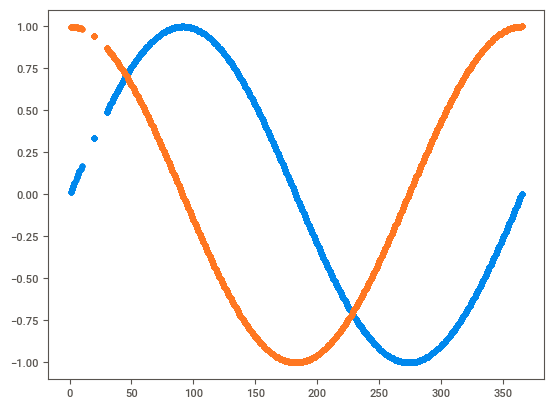

In [68]:
plt.scatter(y = train['yearly_seasonal_1'], x= train['arrival_day_of_year']);
plt.scatter(y = train['yearly_seasonal_2'], x= train['arrival_day_of_year']);

#### How each feature affect the target?

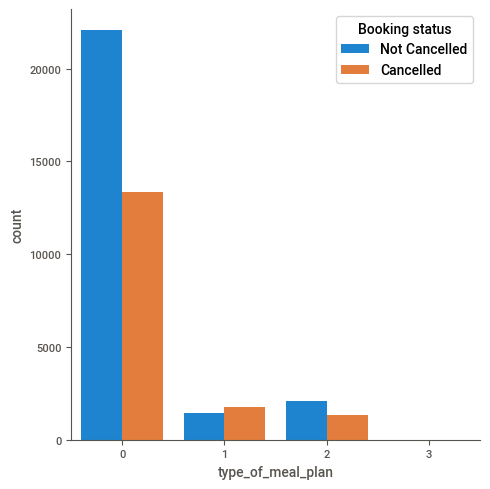

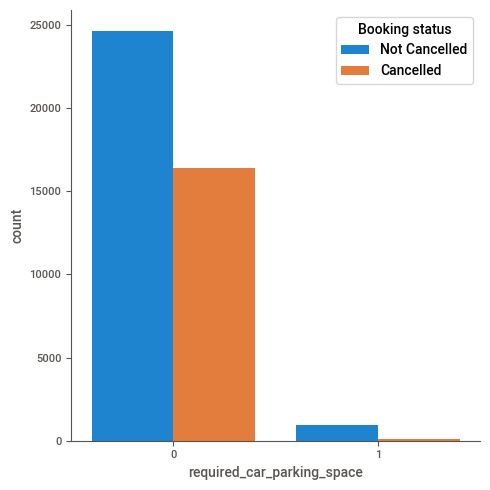

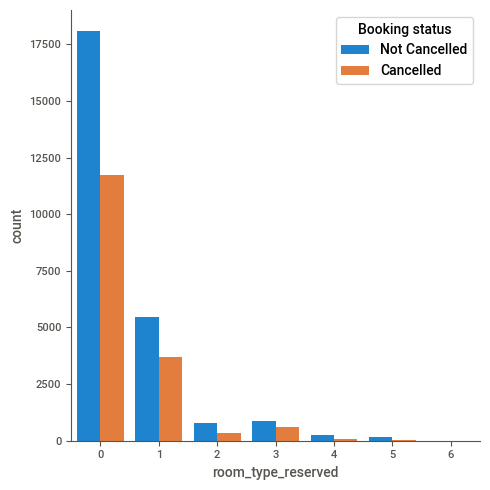

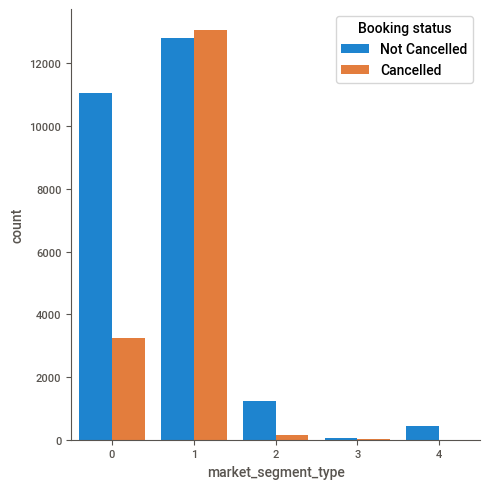

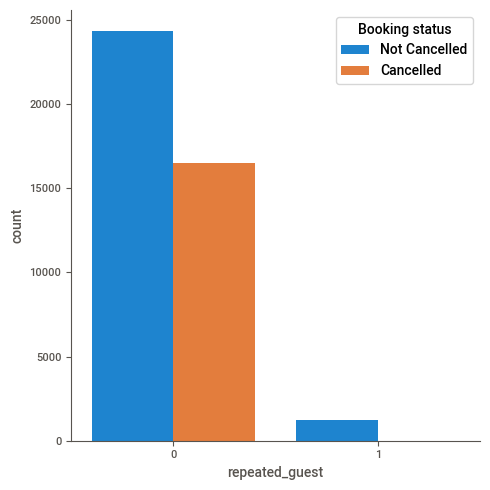

In [23]:
for i in categorical: # Categorical features
    sns.catplot(data=train,x=i, hue='booking_status', kind="count", legend=False,fill=True);
    plt.legend(title='Booking status', labels=['Not Cancelled', 'Cancelled']) 

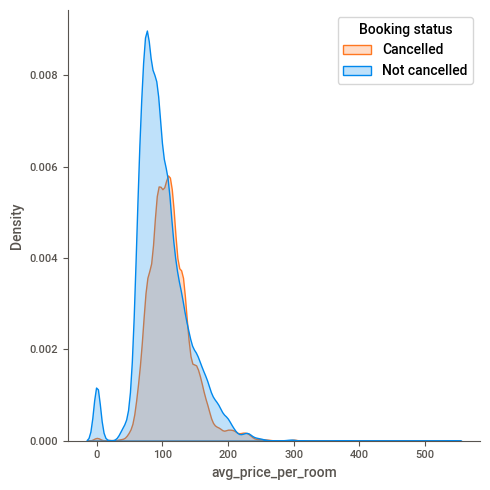

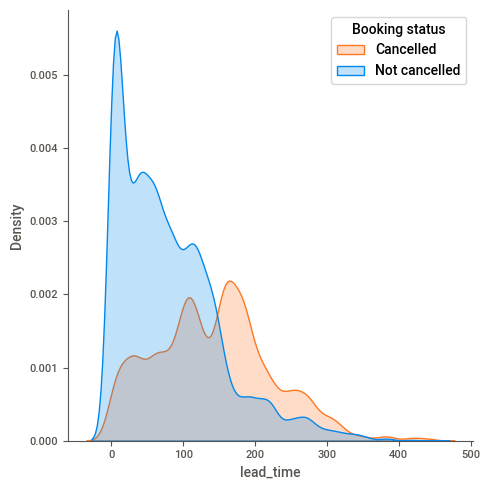

In [24]:
for i in numerical_continous: # numerical continous features
    sns.displot(data=train,x=i,hue='booking_status',legend=False,fill=True,kind='kde');
    plt.legend(title='Booking status', labels=['Cancelled', 'Not cancelled'])

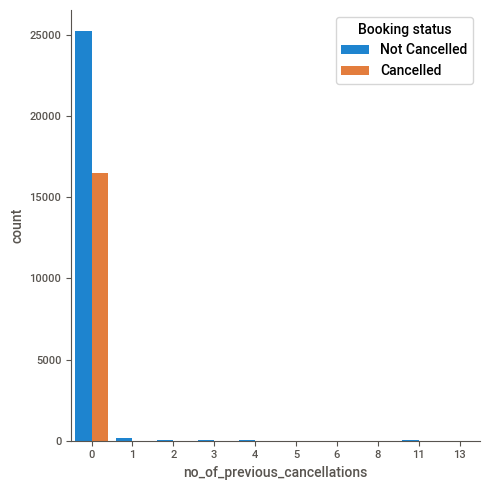

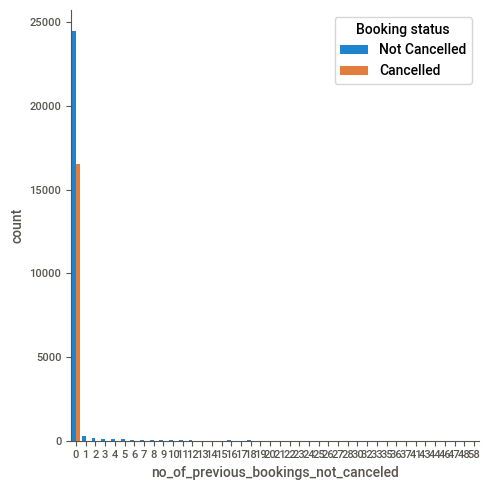

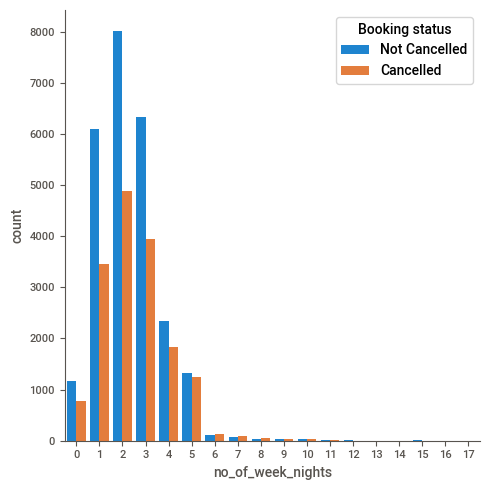

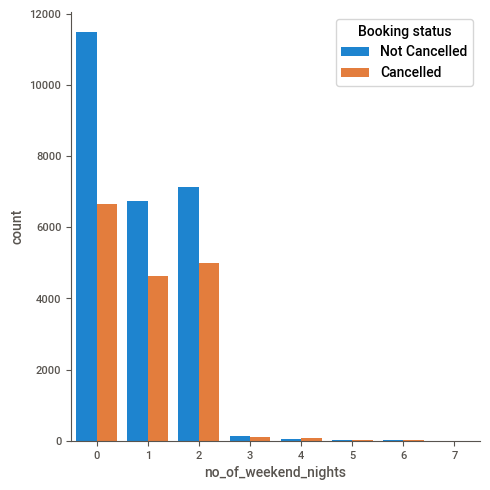

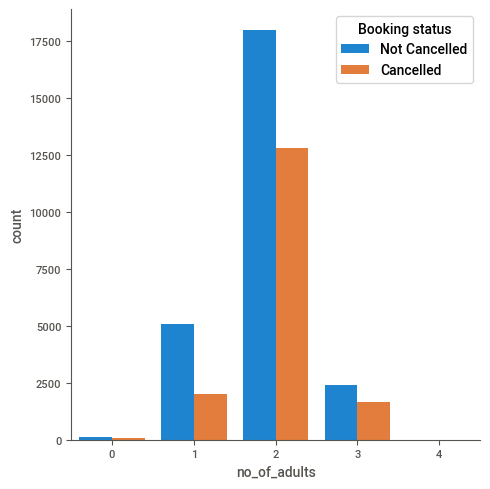

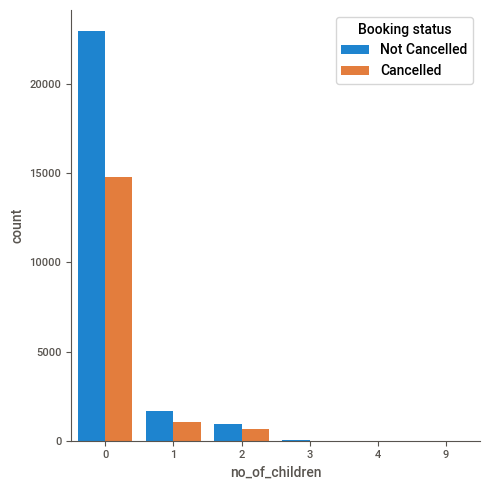

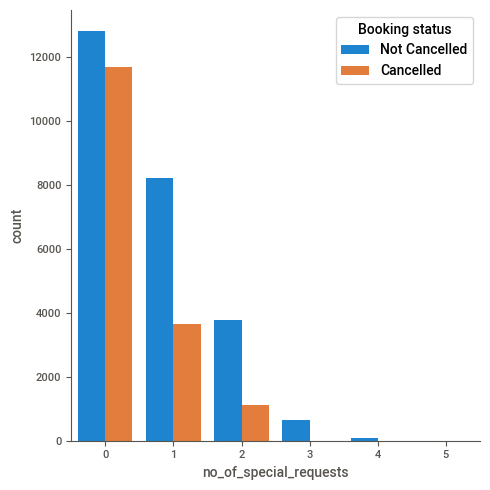

In [44]:
for i in numerical_discrete: # Categorical features
    sns.catplot(data=train,x=i, hue='booking_status', kind="count", legend=False
               # ,fill=False
               );
    #plt.plot(kind="bar", stacked=True, color=["green", "blue"], ax=ax)

    plt.legend(title='Booking status', labels=['Not Cancelled', 'Cancelled']) 

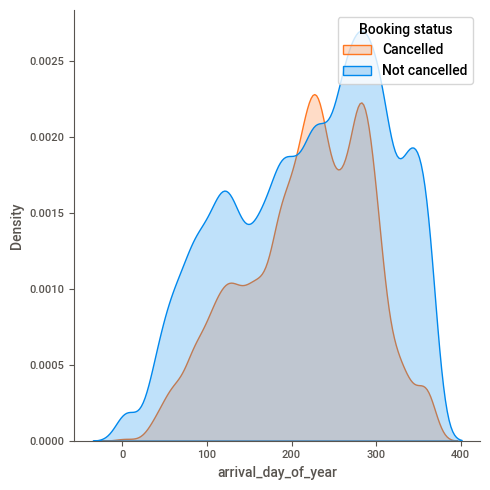

In [51]:
sns.displot(data=train,x='arrival_day_of_year',hue='booking_status',legend=False,fill=True,kind='kde');
plt.legend(title='Booking status', labels=['Cancelled', 'Not cancelled'])

In [52]:
# Let use sweetviz tool to explore the data

my_report = sv.analyze(train)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: no_of_adults                        |███▏                                                                  | [  5%]   00:00 -> (00:00 left)/Users/javierliro/miniforge3/envs/tensorflow+/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Featur

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [73]:
# modified features clasification:

categorical = [
    'type_of_meal_plan',  # One hot encoding
    'required_car_parking_space',# Binary, no need of One hot encoding
    'room_type_reserved', # One hot enconding
    'market_segment_type', # One hot encoding
    'repeated_guest', # Binary, no need of One hot encoding
    'arrival_year', # One hot enconding, Each year can be differnet in terms of booking and cancellations (e.g. natural disasters, economic crisis, etc) 
]
numerical_continous = [
    'avg_price_per_room', 
    'lead_time', # Number of days between the date of booking and the arrival date
    'yearly_seasonal_1' 
    'yearly_seasonal_2'
]

numerical_discrete =[ 
    'no_of_previous_cancellations', 
    'no_of_previous_bookings_not_canceled',
    'no_of_week_nights',  # nteger but meaningful, hence treated as numerical features
    'no_of_weekend_nights',  # nteger but meaningful, hence treated as numerical features
    'no_of_adults', # integer but meaningful, hence treated as numerical features
    'no_of_children',  # integer but meaningful, hence treated as numerical features 
    'no_of_special_requests',  # One hot encoding
]

others = [
    #'arrival_date', # covered by seasonals
    #'arrival_month',# covered by seasonals
]
target = ['booking_status']

# ToDo 
* ML basic
* ML with feature engineenring